In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import mne_connectivity
import glob
import getpass
import importlib
import functions
import spectrogram_plotting_functions
importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

In [ ]:

user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

In [3]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]

for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        print(date, rat_id, task)

        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)



        if 'Keyboard' in channels:
            events = f['Keyboard']
        elif 'keyboard' in channels:
            events = f['keyboard']
        elif 'memory' in channels:
            events = f['memory']
        elif 'Memory' in channels:
            events = f['Memory']

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        all_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels))
        print(all_channels)
        
        mne_baseline_data=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_door_after=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_dig_before=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_dig_after=np.zeros((len(epochs),len(all_channels),4000))
        
        first_event = events_times[0]
        
        for channel_num,channeli in enumerate(all_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)
                
                data_before, time, baseline_mean, baseline_std=functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                normalized_data=functions.zscore_event_data(notch_filtered_data, baseline_mean, baseline_std)

                #baseline_row=[rat_id,task,channel_id,[data_before]]
                #baseline_lfp_all.append(baseline_row)
                #normalized_data, time, data_before = functions.data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                baseline_data_truncated= data_before[-4000:]
                
                mne_baseline_data[0,channel_num,:]=list(baseline_data_truncated)
                
                total = normalized_data

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    #Here we will extract and store the events data
                    data_door_before,data_door_after=functions.extract_door_data(total, time, door_timestamp, sampling_rate)    
                    data_dig_before, data_dig_after=functions.extract_dig_data(total,time, dig_timestamp, sampling_rate)
                    event_data_list=[data_door_before,data_door_after,data_dig_before,data_dig_after]
                    [functions.zscore_event_data(event_data, baseline_mean ,baseline_std) for event_data in event_data_list]
                    mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0])
                    mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1])
                    mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2])
                    mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3])
        if len(all_channels)>0:
            fs=2000
            freqs = np.arange(1,100)
            n_cycles = freqs/2
            info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
            mne_baseline = mne.EpochsArray(mne_baseline_data, info)
            mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
            mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
            mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
            mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
            row_list=[file_num,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after]
            con_data_df.append(row_list)

        # fs=2000
        # freqs = np.arange(1,100)
        # n_cycles = freqs/2
        # info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
        # mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
        # mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
        # mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
        # mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
        # row_list=[rat_id,task,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after]
        # con_data_df.append(row_list)
#baseline_lfp_all = pd.DataFrame(baseline_lfp_all, columns=['rat', 'experiment', 'channel', 'data'])
con_data_df=pd.DataFrame(con_data_df, columns=['experiment','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])


In [ ]:
con_data_df=pd.DataFrame(con_data_df, columns=['rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])

BWcontext_data=con_data_df[(con_data_df['task']=='BWnocontext') & (con_data_df['rat_id']!='dk3')]
print(BWcontext_data.shape)
fig,axs=plt.subplots(3,4, sharex=True, sharey=True, figsize=(20,10))
axs=axs.flatten()
fig.suptitle('BW Context Post Door AON-vHp Granger Causality')
for trial in range(BWcontext_data.shape[0]):
    trial_epoch=BWcontext_data['mne_epoch_door_after'].iloc[trial]
    print("trial_epoch")
    trial_id =f"{BWcontext_data['rat_id'].iloc[trial]} {BWcontext_data['task'].iloc[trial]}"
    print(trial_id)
    aon_signals=[
        idx
        for idx, ch_info in enumerate(trial_epoch.info["chs"])
        if "AON" in ch_info["ch_name"]
    ]
    print(aon_signals)
    vhp_signals=[
        idx
        for idx, ch_info in enumerate(trial_epoch.info["chs"])
        if "vHp" in ch_info["ch_name"]
    ]
    print(vhp_signals)

    indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
    indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))
    gc_ab = mne_connectivity.spectral_connectivity_epochs(
        trial_epoch,
        method=["gc"],
        indices=indices_aon_vhp,
        fmin=2.5,
        fmax=100,
        rank=None,
        gc_n_lags=20,
    )
    freqs = gc_ab.freqs

    gc_ba = mne_connectivity.spectral_connectivity_epochs(
        trial_epoch,
        method=["gc"],
        indices=indices_vhp_aon,
        fmin=2.5,
        fmax=100,
        rank=None,
        gc_n_lags=20,
    )
    freqs = gc_ba.freqs

    net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
    ax=axs[trial]
    ax.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    ax.plot(freqs, net_gc[0], linewidth=2)
    ax.set_title(f"{BWcontext_data['rat_id'].iloc[trial]} ", fontsize=8)
fig.tight_layout()
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\BWnocontext_post_door_aon_vhp_gc.png')

In [ ]:
con_data_df=pd.DataFrame(con_data_df, columns=['rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])
con_data_df_clean=con_data_df[con_data_df['rat_id']!='dk3']


events_dict={'mne_epoch_door_before':'door before','mne_epoch_door_after':'door after','mne_epoch_dig_before':'dig before','mne_epoch_dig_after':'dig after'}

def calculate_net_gc(mne_data):
        aon_signals=[
        idx
        for idx, ch_info in enumerate(mne_data.info["chs"])
        if "AON" in ch_info["ch_name"]
        ]
        print(aon_signals)
        vhp_signals=[
            idx
            for idx, ch_info in enumerate(mne_data.info["chs"])
            if "vHp" in ch_info["ch_name"]
        ]
        print(vhp_signals)

        indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
        indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))

        gc_ab = mne_connectivity.spectral_connectivity_epochs(
        mne_data,
        method=["gc"],
        indices=indices_aon_vhp,
        fmin=2.5,
        fmax=100,
        rank=None,
        gc_n_lags=20,
        )
        freqs = gc_ab.freqs

        gc_ba = mne_connectivity.spectral_connectivity_epochs(
            mne_data,
            method=["gc"],
            indices=indices_vhp_aon,
            fmin=2.5,
            fmax=100,
            rank=None,
            gc_n_lags=20,
        )
        freqs = gc_ba.freqs

        net_gc = gc_ab.get_data() - gc_ba.get_data()
        return net_gc[0]

gc_data_df=pd.DataFrame()
gc_data_df['rat_id']=con_data_df_clean['rat_id']
gc_data_df['task']=con_data_df_clean['task']
gc_data_df['door_before']=con_data_df_clean['mne_epoch_door_before'].apply(lambda x: calculate_net_gc(x))
gc_data_df['door_after']=con_data_df_clean['mne_epoch_door_after'].apply(lambda x: calculate_net_gc(x))
gc_data_df['dig_before']=con_data_df_clean['mne_epoch_dig_before'].apply(lambda x: calculate_net_gc(x))
gc_data_df['dig_after']=con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: calculate_net_gc(x))

gc_data_df=pd.DataFrame(gc_data_df, columns=['rat_id','task','door_before','door_after','dig_before','dig_after'])



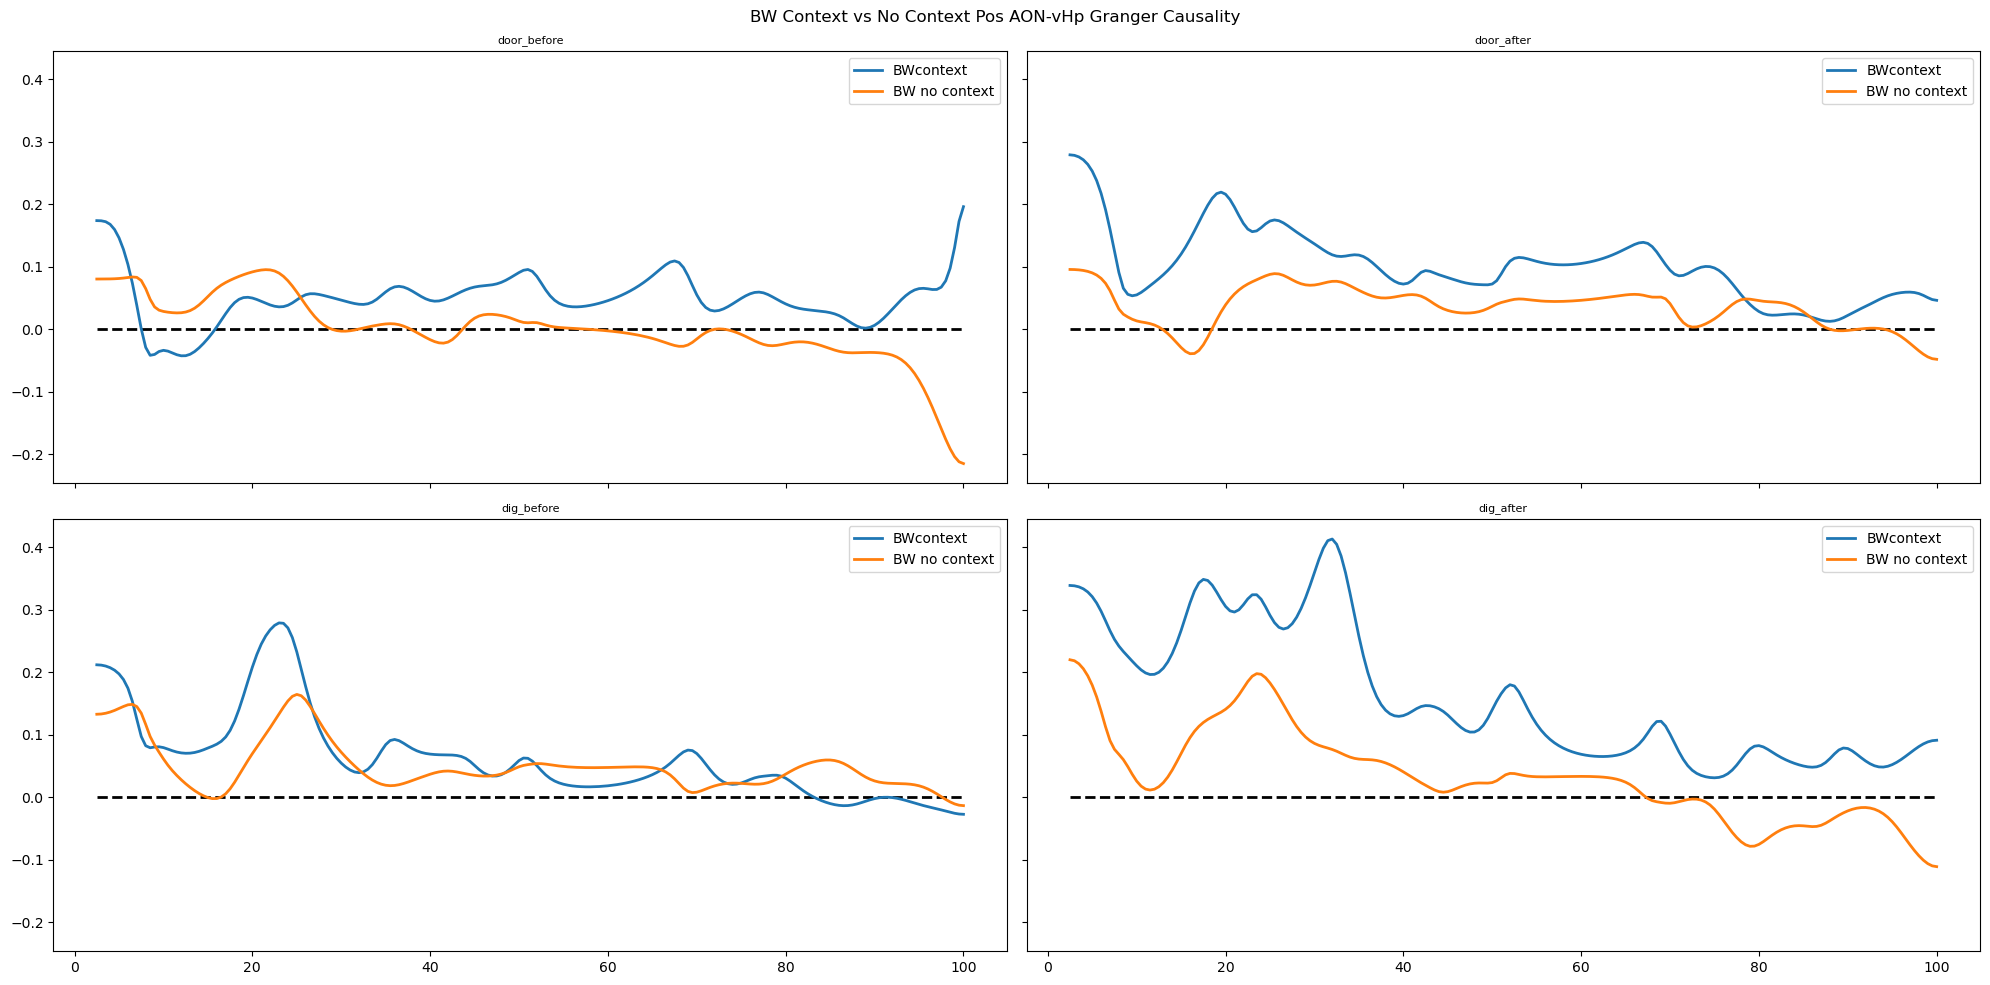

In [26]:
gc_data_df_bwcontext=gc_data_df[gc_data_df['task']=='BWcontext']
gc_data_df_bwnocontext=gc_data_df[gc_data_df['task']=='BWnocontext']

fig,axs=plt.subplots(2,2, sharex=True, sharey=True, figsize=(20,10))
axs=axs.flatten()
fig.suptitle('BW Context vs No Context Pos AON-vHp Granger Causality')
events=['door_before','door_after','dig_before','dig_after']
for i,event in enumerate(events):
    ax=axs[i]
    ax.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    ax.plot(freqs, gc_data_df_bwcontext[event].mean(), linewidth=2, label='BWcontext')
    ax.plot(freqs, gc_data_df_bwnocontext[event].mean(), linewidth=2, label='BW no context')
    ax.set_title(f"{event}", fontsize=8)
    ax.legend()
fig.tight_layout()
plt.show()

In [ ]:


fig,axs=plt.subplots(3,4, sharex=True, sharey=True, figsize=(20,10))


axs=axs.flatten()
fig.suptitle('BW Context Post Door AON-vHp Granger Causality')
for trial in range(BWcontext_data.shape[0]):
    trial_epoch=BWcontext_data['mne_epoch_door_after'].iloc[trial]
    print("trial_epoch")
    trial_id =f"{BWcontext_data['rat_id'].iloc[trial]} {BWcontext_data['task'].iloc[trial]}"
    print(trial_id)
    aon_signals=[
        idx
        for idx, ch_info in enumerate(trial_epoch.info["chs"])
        if "AON" in ch_info["ch_name"]
    ]
    print(aon_signals)
    vhp_signals=[
        idx
        for idx, ch_info in enumerate(trial_epoch.info["chs"])
        if "vHp" in ch_info["ch_name"]
    ]
    print(vhp_signals)

    indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
    indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))
    gc_ab = mne_connectivity.spectral_connectivity_epochs(
        trial_epoch,
        method=["gc"],
        indices=indices_aon_vhp,
        fmin=2.5,
        fmax=100,
        rank=None,
        gc_n_lags=20,
    )
    freqs = gc_ab.freqs

    gc_ba = mne_connectivity.spectral_connectivity_epochs(
        trial_epoch,
        method=["gc"],
        indices=indices_vhp_aon,
        fmin=2.5,
        fmax=100,
        rank=None,
        gc_n_lags=20,
    )
    freqs = gc_ba.freqs

    net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
    ax=axs[trial]
    ax.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    ax.plot(freqs, net_gc[0], linewidth=2)
    ax.set_title(f"{BWcontext_data['rat_id'].iloc[trial]} ", fontsize=8)
fig.tight_layout()
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\BWnocontext_post_door_aon_vhp_gc.png')